# Environment setup

In [ ]:
# Prepare the running environment.
import os
if os.getenv("KAGGLE_KERNEL_RUN_TYPE"):
    # Kaggle Run: update the system.
    !pip uninstall -qqy google-ai-generativelanguage pydrive2 tensorflow tensorflow-decision-forests cryptography pyOpenSSL langchain langchain-core nltk ray click google-generativeai google-cloud-translate datasets cesium bigframes plotnine mlxtend fastai spacy thinc google-colab gcsfs jupyter-kernel-gateway nltk preprocessing gradio dopamine-rl torchtune
    !pip install -qU posthog\<6.0.0 google-genai==1.50.0 chromadb==0.6.3 opentelemetry-proto==1.37.0 numpy==1.26.4 opencv-contrib-python==4.11.0.86 pillow==10.4.0 websockets==11.0.3
    !pip install -qU langchain-community langchain-text-splitters google-adk google-adk[eval] google-cloud-translate
    !pip install -qU torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cpu
    from kaggle_secrets import UserSecretsClient # type: ignore
else:
    # Local Run: update the venv.
    %pip install -qU gradio_imageslider gradio matplotlib chromadb==0.6.3 pandas google-api-core ollama google-adk "google-adk[eval]" google-genai pillow opencv-contrib-python screeninfo
    %pip install -qU torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cpu

import asyncio, cv2, io, IPython, sys, time, torch, numpy as np
from google import genai
from google.api_core import retry, exceptions
from google.genai.models import Models
from google.genai import types, errors
from io import BytesIO
from IPython.display import HTML, display
from matplotlib import pyplot as plt
from pathlib import Path
from PIL import Image
from screeninfo import get_monitors

# Init / update submodules.
!git submodule update --init --recursive
submodule_path = os.path.join(Path.cwd(), 'external', 'Depth-Anything-V2')
if submodule_path not in sys.path:
    sys.path.append(submodule_path)
from depth_anything_v2.dpt import DepthAnythingV2

from rb1 import *

# Init depth estimation model.
init_model(DA2Model.Large)


In [ ]:
img_in = Image.open("docs/src/vales_of_anduin_sketch.jpg")

prompt = """Do something cool with this image to show off your skills."""

In [ ]:
# Cannot generate images or video.
# But it can reason about them.
response = client.models.generate_content(
    model="gemini-3-pro-preview",
    contents=[prompt, img_in],
)

print(response.text)

This is a fantastic hand-drawn map of Middle-earth, specifically focusing on the Wilderland (Rhovanion) and Gondor.

To "show off," I’m not just going to describe the image—I’m going to **analyze your specific cartographic choices** (which reveal you know your deep Tolkien lore) and then **convert your map into a functional code-based navigation system.**

### 1. The "Deep Lore" Analysis
You haven't just drawn the standard map from the back of *The Return of the King*. You’ve drawn a map that likely reflects the **Second Age** or the very early **Third Age**, possibly from an Entish or Elvish perspective.

*   **Evidence A: "Lindórinand"**: You used the Nandorin name for Lothlórien ("Vale of the Land of the Singers"). This name fell out of use after the Silvan Elves adopted Sindarin.
*   **Evidence B: "Ambaróna" & "Aldalómë"**: These are Quenya names (meaning "Eastern Earth" and "Tree-twilight") famously used by Treebeard to describe the great forests before they were split into Fangorn and Mirkwood.
*   **Evidence C: "Greenwood"**: You didn't label it "Mirkwood," implying this map exists before the Shadow fell on the forest (approx. T.A. 1050).

### 2. Gamifying Your Map (Python)
I have converted the visual topology of your river systems (the pink lines) into a Python graph. The code below creates a text-based "GPS" that navigates the specific layout you drew, calculating danger levels based on the proximity to Mordor/Dol Guldur as shown in your sketch.

```python
import networkx as nx
import random

class MiddleEarthMap:
    def __init__(self):
        # Creating a directed graph based on the flow of rivers in your drawing
        self.map_graph = nx.DiGraph()
        self.setup_locations()
        self.setup_river_routes()

    def setup_locations(self):
        # Locations identified from your handwriting via OCR analysis
        self.locations = {
            "Ered Mithrin": {"type": "Mountain", "danger": 7},
            "Erebor": {"type": "Stronghold", "danger": 3},
            "Esgaroth": {"type": "City", "danger": 4},
            "Greenwood Forest": {"type": "Forest", "danger": 6},
            "Anduin Valley": {"type": "Plains", "danger": 2},
            "Nen Hithoel": {"type": "Lake", "danger": 5},
            "Falls of Rauros": {"type": "Waterfall", "danger": 8},
            "Udûn": {"type": "Evil", "danger": 10},
            "Bay of Belfalas": {"type": "Ocean", "danger": 1},
        }

    def setup_river_routes(self):
        # Mapping the PINK lines you drew as navigable edges
        # Format: (Start, End, Travel_Days)
        routes = [
            ("Ered Mithrin", "Greenwood Forest", 5),
            ("Erebor", "Esgaroth", 2),
            ("Esgaroth", "Anduin Valley", 6),
            ("Greenwood Forest", "Anduin Valley", 4),
            ("Anduin Valley", "Nen Hithoel", 5),
            ("Nen Hithoel", "Falls of Rauros", 1),
            ("Falls of Rauros", "Bay of Belfalas", 10) # The long stretch south
        ]
        self.map_graph.add_weighted_edges_from(routes)

    def plan_journey(self, start, end):
        try:
            path = nx.shortest_path(self.map_graph, start, end, weight='weight')
            total_danger = sum(self.locations[loc]["danger"] for loc in path)
            
            print(f"🗺️  JOURNEY PLANNER: {start} -> {end}")
            print(f"----------------------------------------")
            print(f"📍 Route: {' -> '.join(path)}")
            print(f"⚠️  Cumulative Danger Rating: {total_danger}/50")
            
            if "Falls of Rauros" in path:
                print("❗ WARNING: Portage required at Falls of Rauros.")
            if "Udûn" in path:
                print("☠️  CRITICAL: One does not simply walk into this node.")
                
        except nx.NetworkXNoPath:
            print(f"❌ No river route connects {start} to {end} on this map.")

# Let's run a simulation based on your map data
navigator = MiddleEarthMap()

# Scenario: A raft escaping the North to reach the Sea
navigator.plan_journey("Erebor", "Bay of Belfalas")
```

### 3. The Narrative Output
Based on the code simulation and your drawing, here is the generated log for the route highlighted in pink:

> **The Riverlog of the Lonely Mountain**
>
> We departed **Erebor** under the shadow of the Mountain. The current took us swiftly to **Esgaroth** (Long Lake). Following your map's pink contours, we merged into the Great River.
>
> To our right, the trees of **Lindórinand** loomed—golden and strange. To our left, the peaks of **Ered Lithui** jagged against the sky like broken teeth.
>
> The most treacherous point was the red-circled zone on your parchment: **Nen Hithoel**. The current accelerated. We barely made shore before the roar of the **Falls of Rauros**. From there, it was a long drift past the mouths of the Entwash (Onodló) until the air turned salty and the White Mountains (Ered Nimrais) faded into the **Bay of Belfalas**.

**Verdict:** Great work on the map. The inclusion of archaic geography (Aldalómë/Ambaróna) makes it a sophisticated piece of cartography!

## Image Generation

In [ ]:
# Capable of editing and generating.
response = client.models.generate_content(
    model="gemini-3-pro-image-preview",
    contents=[prompt, img_in],
)

for part in response.candidates[0].content.parts:
    if part.text:
        print(part.text)
    elif part.inline_data is not None:
        image = Image.open(BytesIO(part.inline_data.data))
        image.save("docs/results/img_out.png")

In [2]:
display(side_by_side(
    "docs/src/vales_of_anduin_sketch.jpg", 
    "docs/results/map_one_shot.png"))

In [ ]:
# Can only generate, no editing.
def generate_image(prompt):
    result = client.models.generate_images(
        model="imagen-4.0-ultra-generate-001", # imagen-4.0-generate-001, imagen-4.0-fast-generate-001
        prompt=prompt,
        config=dict(aspect_ratio="16:9", image_size="2k") # person_generation="DONT_ALLOW"
    )
    for n, generated_image in enumerate(result.generated_images):
        generated_image.image.save(f"docs/results/scene_{n}.jpg")
        generated_image.image.show()

In [ ]:
# Capable of editing and generating.
result = client.models.generate_content(
    model="gemini-2.5-flash-image", # gemini-2.5-flash-image-preview
    contents=[prompt, img_in]
)

for part in result.candidates[0].content.parts:
    if part.text:
        print(part.text)
    elif part.inline_data is not None:
        image = Image.open(BytesIO(part.inline_data.data))
        image.save("docs/results/img_out.png")

Image.open("docs/results/img_out.png")

## Video Generation

In [ ]:
# Capable of editing and generating.
def generate_video(image, prompt):
    # Converting the image to bytes
    image_bytes_io = io.BytesIO()
    image.save(image_bytes_io, format=image.format)
    image_bytes = image_bytes_io.getvalue()

    operation = client.models.generate_videos(
        model="veo-3.0-generate-001", # veo-3.0-generate-001, veo-3.0-fast-generate-001
        prompt=prompt,
        image=types.Image(image_bytes=image_bytes, mime_type=image.format),
        config=types.GenerateVideosConfig(
            aspect_ratio="16:9",
            number_of_videos=1))
    
    while not operation.done:
        print("Waiting for video generation to complete...")
        time.sleep(10)
        operation = client.operations.get(operation)

    return operation.result.generated_videos[0]

## Audio Generation

In [ ]:
lyria_client = genai.Client(
    api_key=GOOGLE_API_KEY,
    http_options={'api_version': 'v1alpha'}, # Lyria is only experimental.
)

music_prompts = [
    {"text": "Piano", "weight": 2.0},
    types.WeightedPrompt(text="Meditation", weight=0.5),
    types.WeightedPrompt(text="Live Performance", weight=1.0),
]

music_config = types.LiveMusicGenerationConfig(
    bpm=128,
    scale=types.Scale.D_MAJOR_B_MINOR,
    music_generation_mode=types.MusicGenerationMode.QUALITY
)

async def generate_music(prompts: list, config: types.LiveMusicGenerationConfig):
    # Background task to process incoming audio.
    async def receive_audio(session):
        while True:
            async for message in session.receive():
                audio_data = message.server_content.audio_chunks[0].data
                # Process audio...
                await asyncio.sleep(10**-12)

    async with (
        lyria_client.aio.live.music.connect(model='models/lyria-realtime-exp') as session,
        asyncio.TaskGroup() as tg,
    ):
        # Set up task to receive server messages.
        tg.create_task(receive_audio(session))

        # Send initial prompts and config
        await session.set_weighted_prompts(prompts=music_prompts)
        await session.set_music_generation_config(config=config)

        # Start streaming music
        await session.play()

In [ ]:
asyncio.run(generate_music(music_prompts, music_config))

## Depth Estimation

infer_depth: using cpu backend


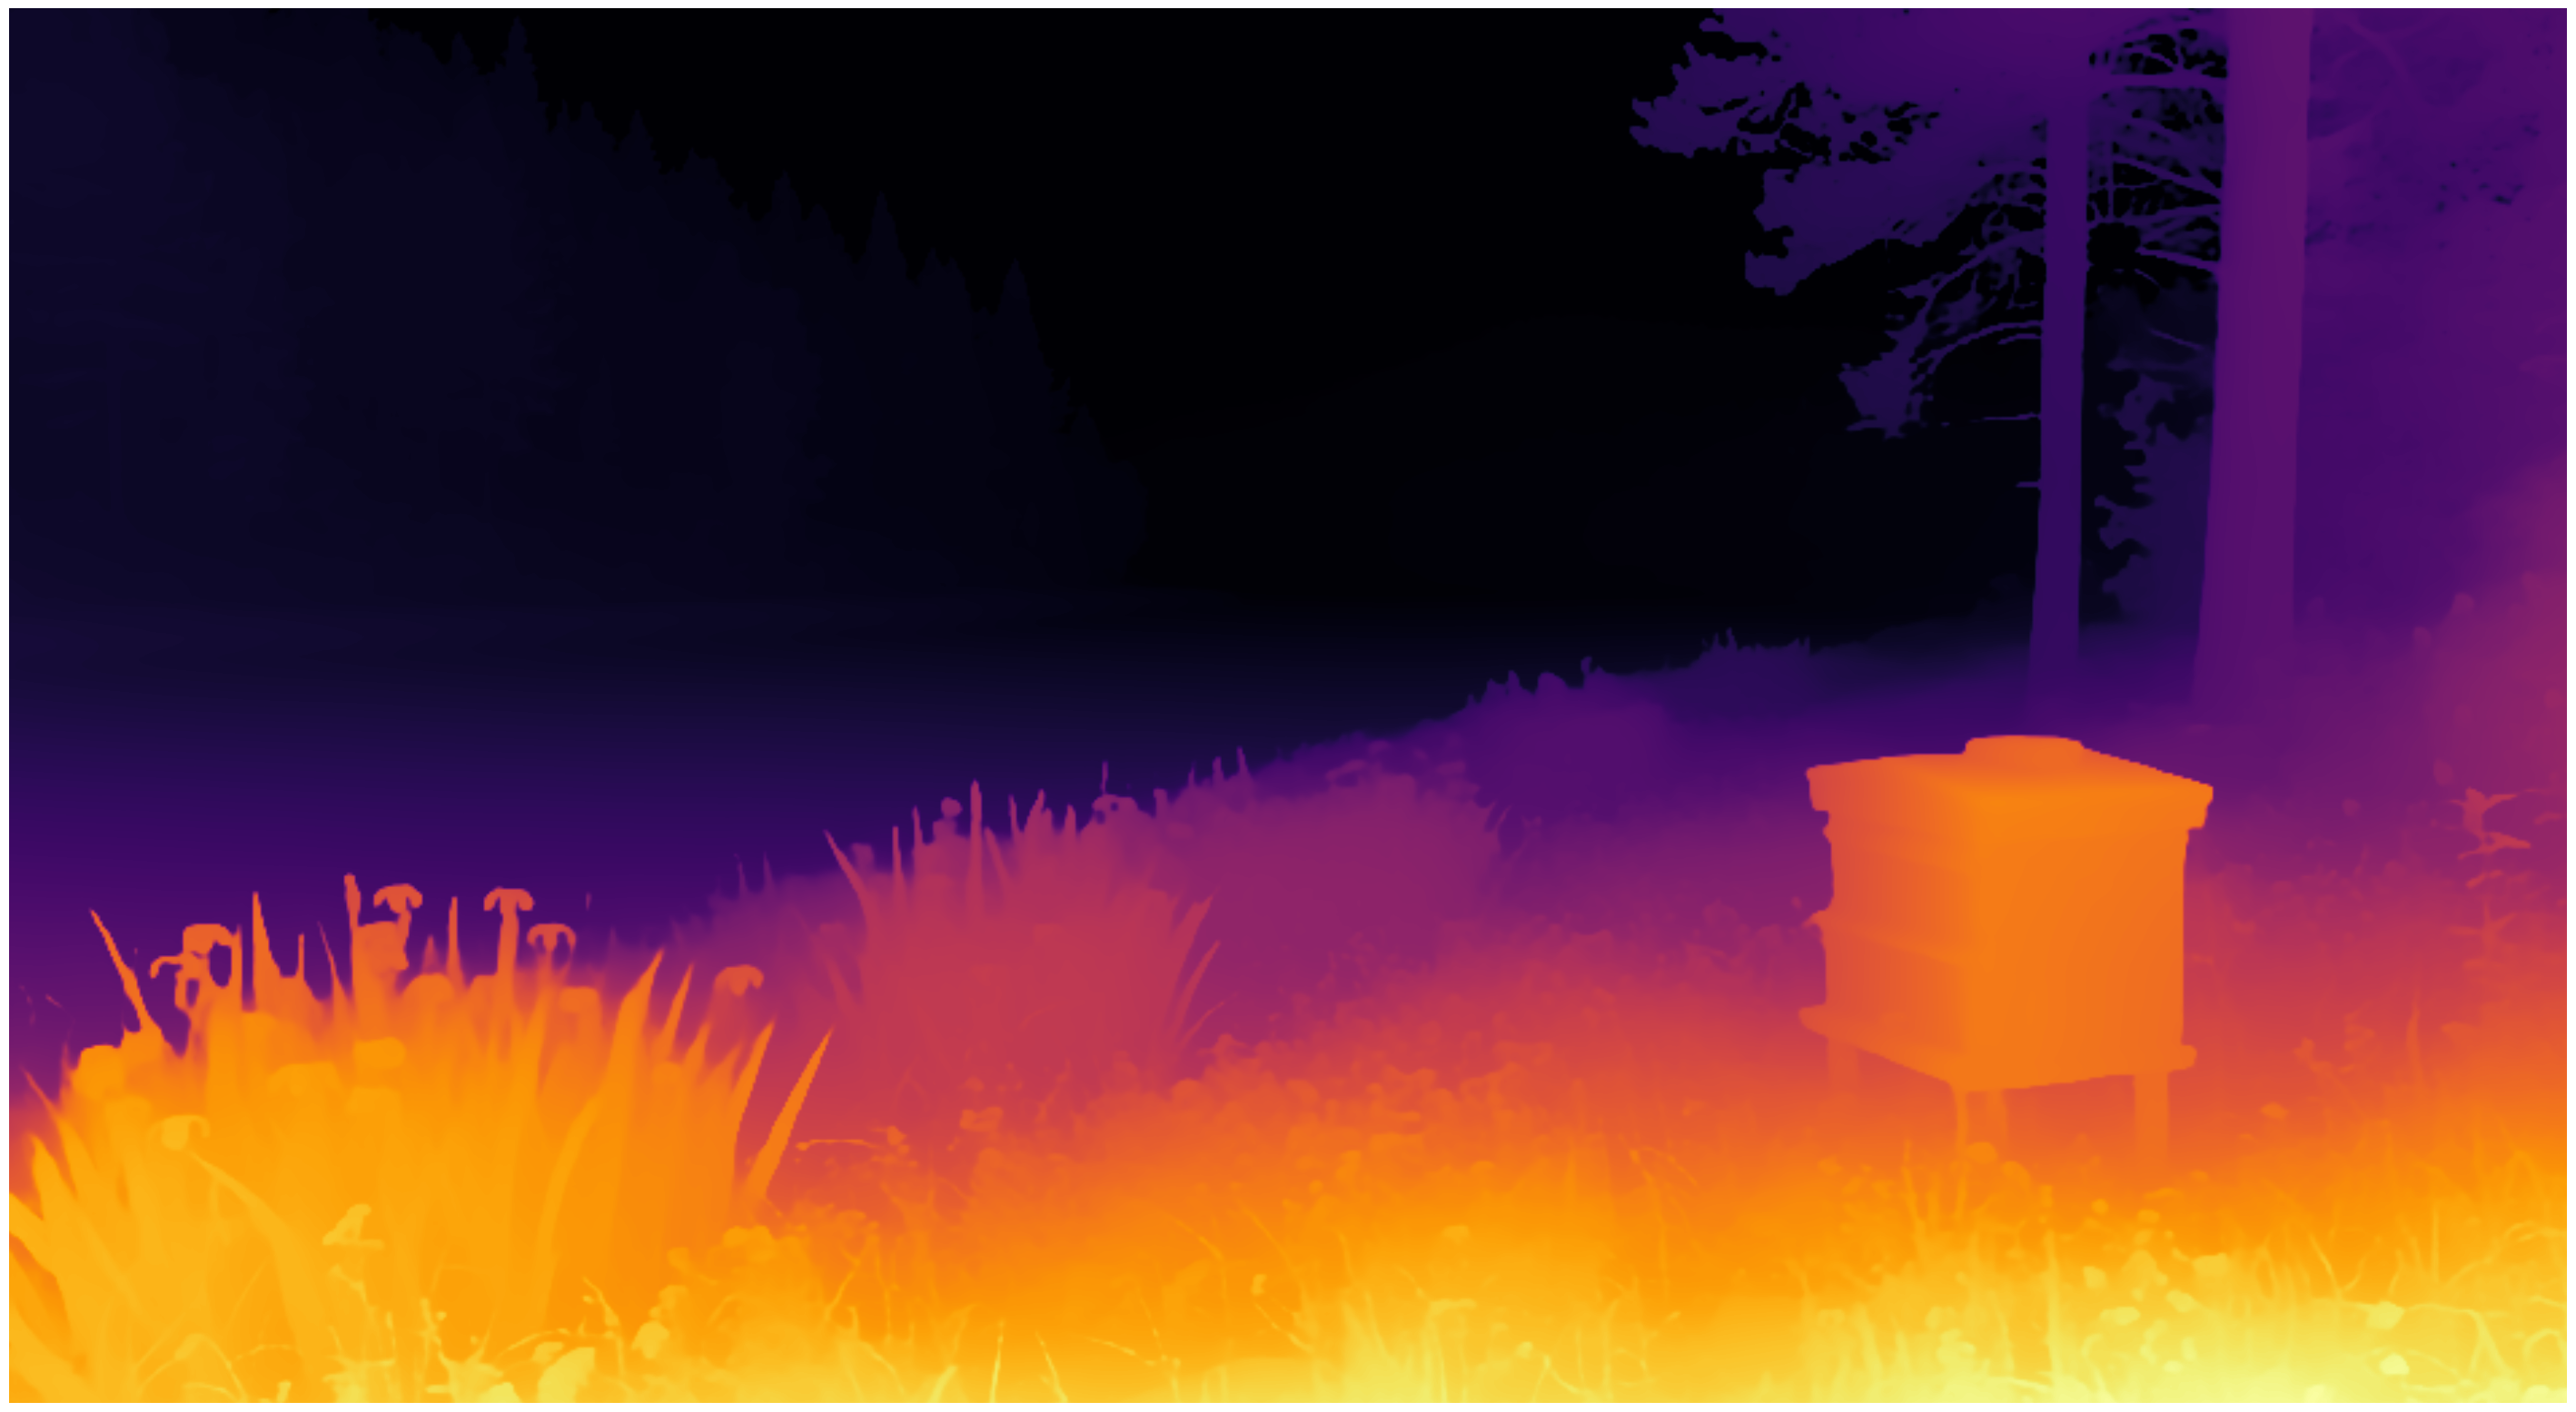

In [4]:
depth = infer_depth('docs/src/scene_4.jpg')
heatmap = depth_to_heatmap(depth)
show_full_width(heatmap)